- missingno : 결츨 데이터 검색
- sklearn.impute : 결측 데이터 대체
- patsy : 데이터 선택, 변환, 추가, 스케일링
- sklearn.preprocessing : 스케일링 변환

## missingno

예제 데이터 생성

In [3]:
from io import StringIO

csv_data = StringIO("""
x1,x2,x3,x4,x5
1,0.1,"1",2019-01-01,A
2,,,2019-01-02,B
3,,"3",2019-01-03,C
,0.4,"4",2019-01-04,A
5,0.5,"5",2019-01-05,B
,,,2019-01-06,C
7,0.7,"7",,A
8,0.8,"8",2019-01-08,B
9,0.9,,2019-01-09,C
""")

df = pd.read_csv(csv_data, dtype={"x1": pd.Int64Dtype()}, parse_dates=[3])
df

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
1,2,NaN,NaN,2019-01-02,B
2,3,NaN,3.0,2019-01-03,C
3,<NA>,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
5,<NA>,NaN,NaN,2019-01-06,C
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,NaN,2019-01-09,C


결측치 확인

In [4]:
df.isnull().sum()

x1    2
x2    3
x3    3
x4    1
x5    0
dtype: int64

결측치 시각화

- 우측의 선은 spark line이라 부르며 각 행의 데이터 완성도를 표현

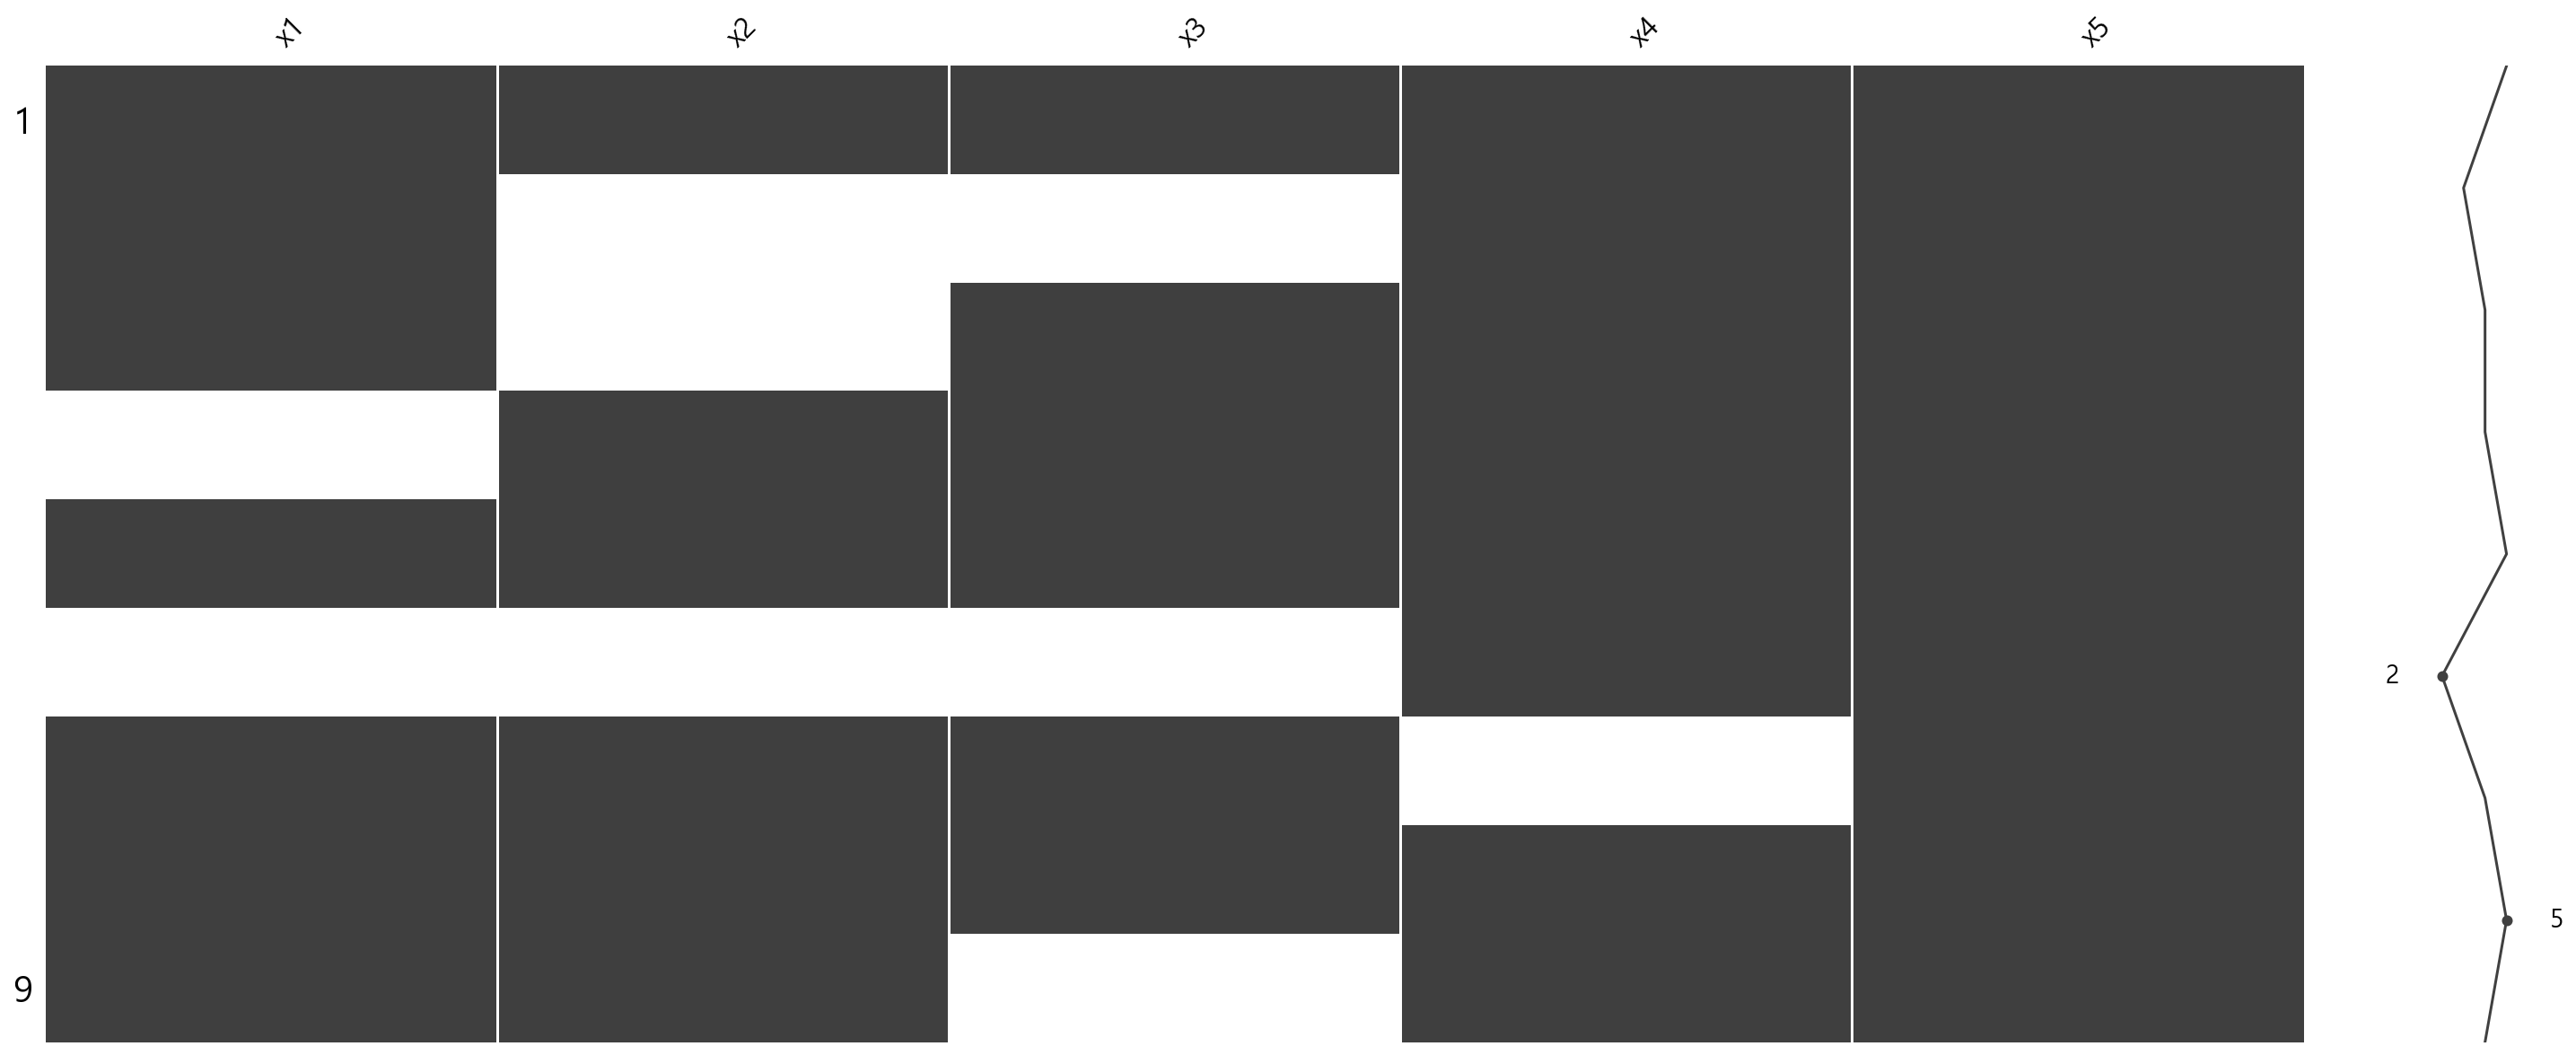

In [5]:
import missingno as msno

msno.matrix(df)
plt.show()

bar 명령의 경우 결측치가 아닌 데이터가 얼마나 존재하는지를 확인할 수 있다.

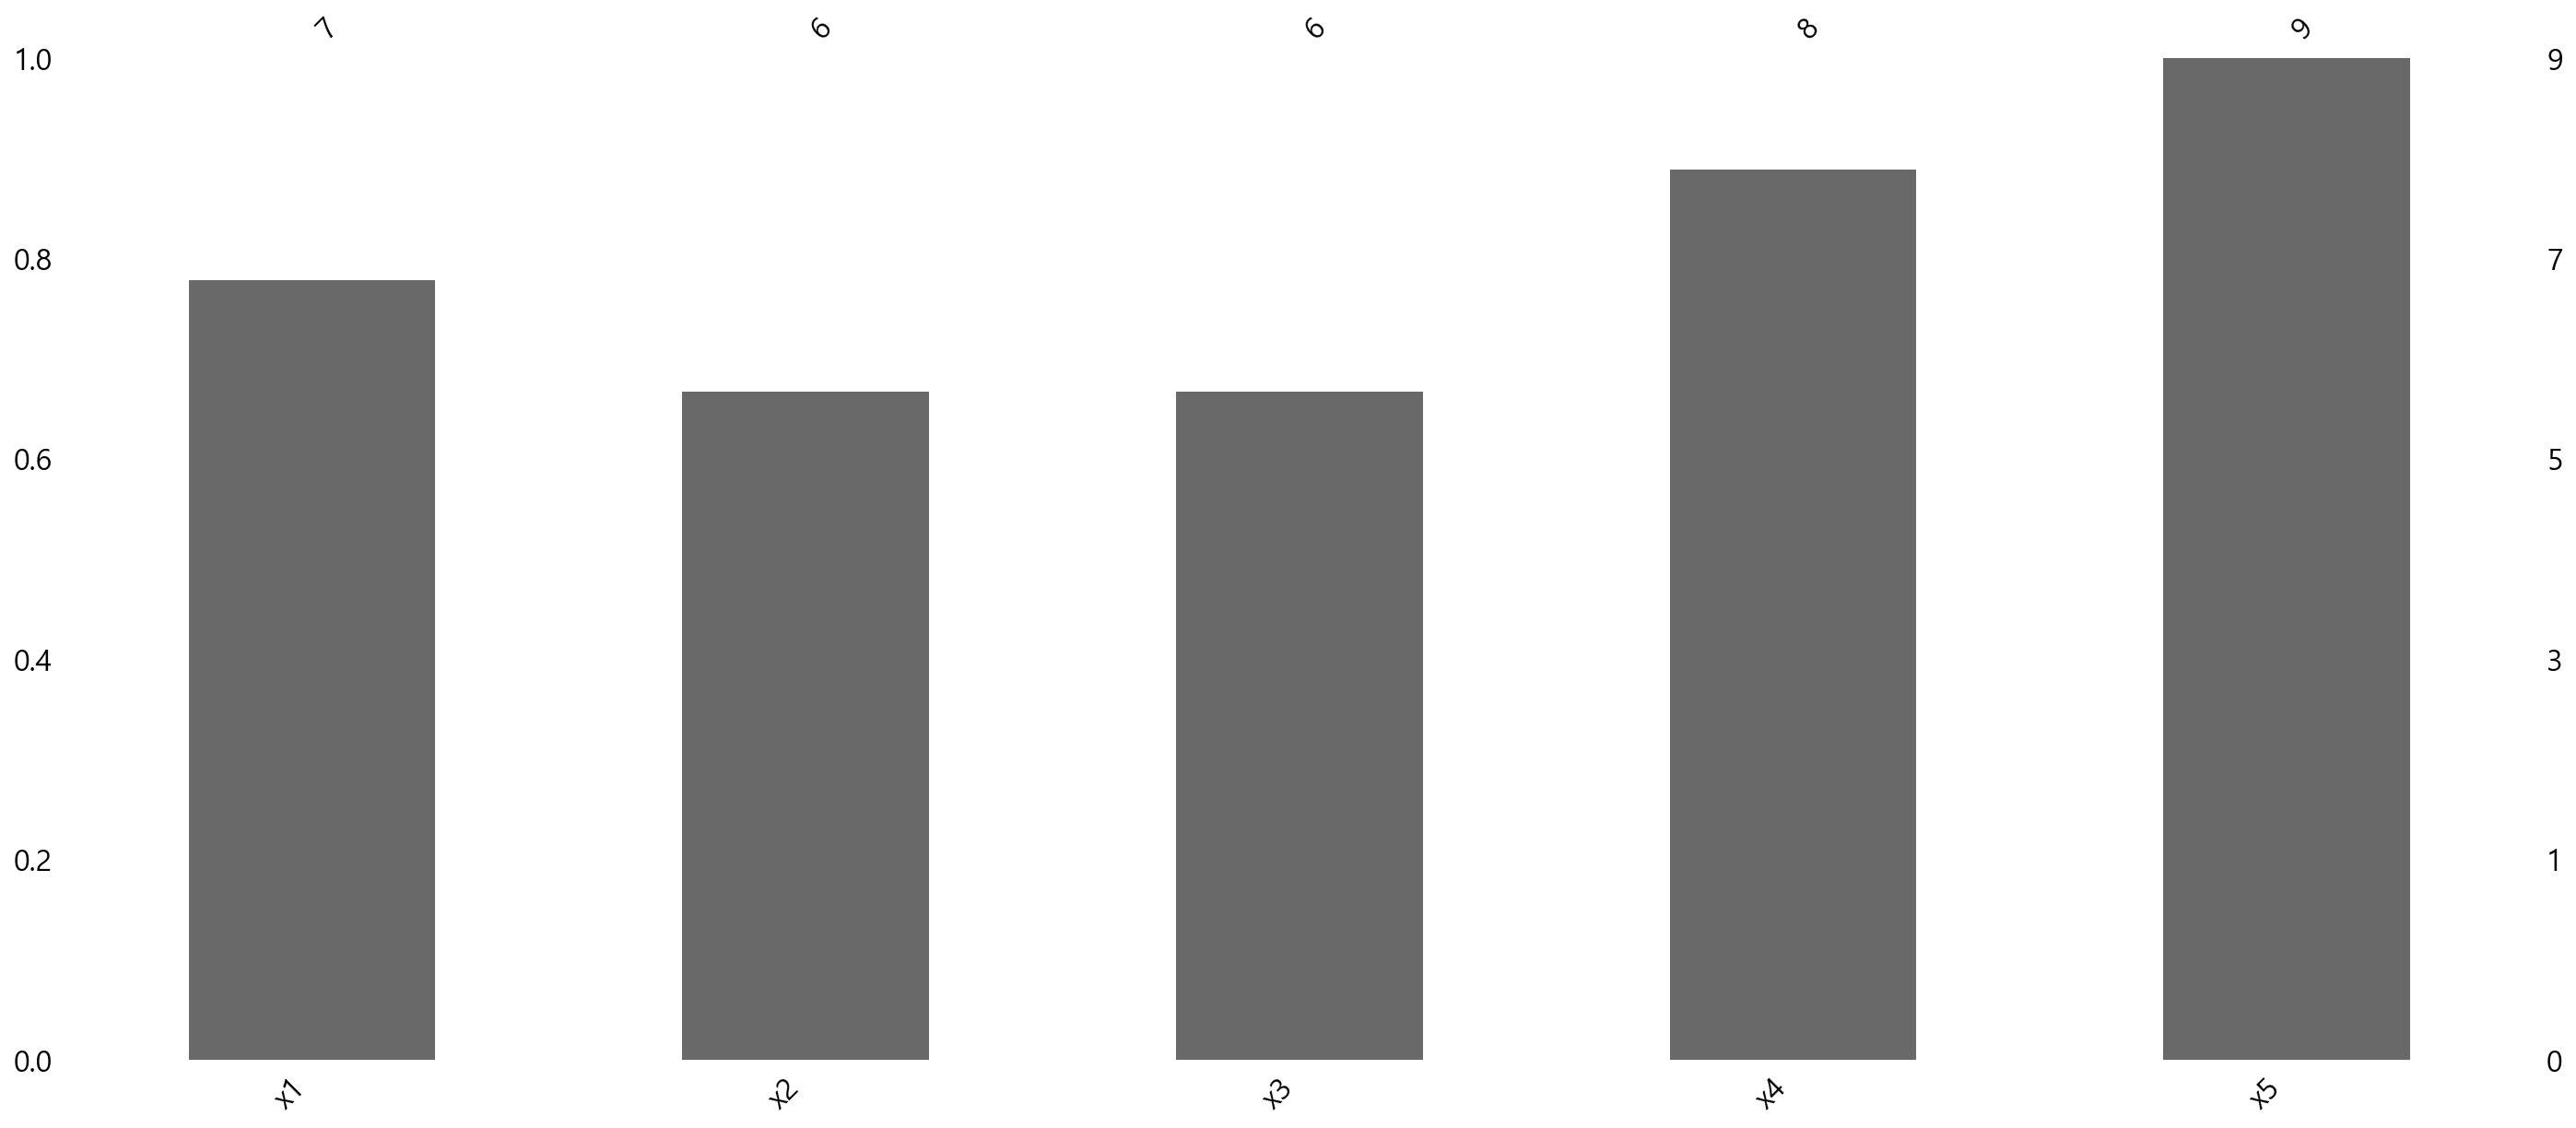

In [6]:
msno.bar(df)
plt.show()

> missingno 패키지는 데이터가 방대한 경우 그 위력이 발휘된다!

In [7]:
titanic = sns.load_dataset("titanic")
titanic.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
886,0,2,male,27.0,0,0,13.00,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.00,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.45,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.00,C,First,man,True,C,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.75,Q,Third,man,True,NaN,Queenstown,no,True


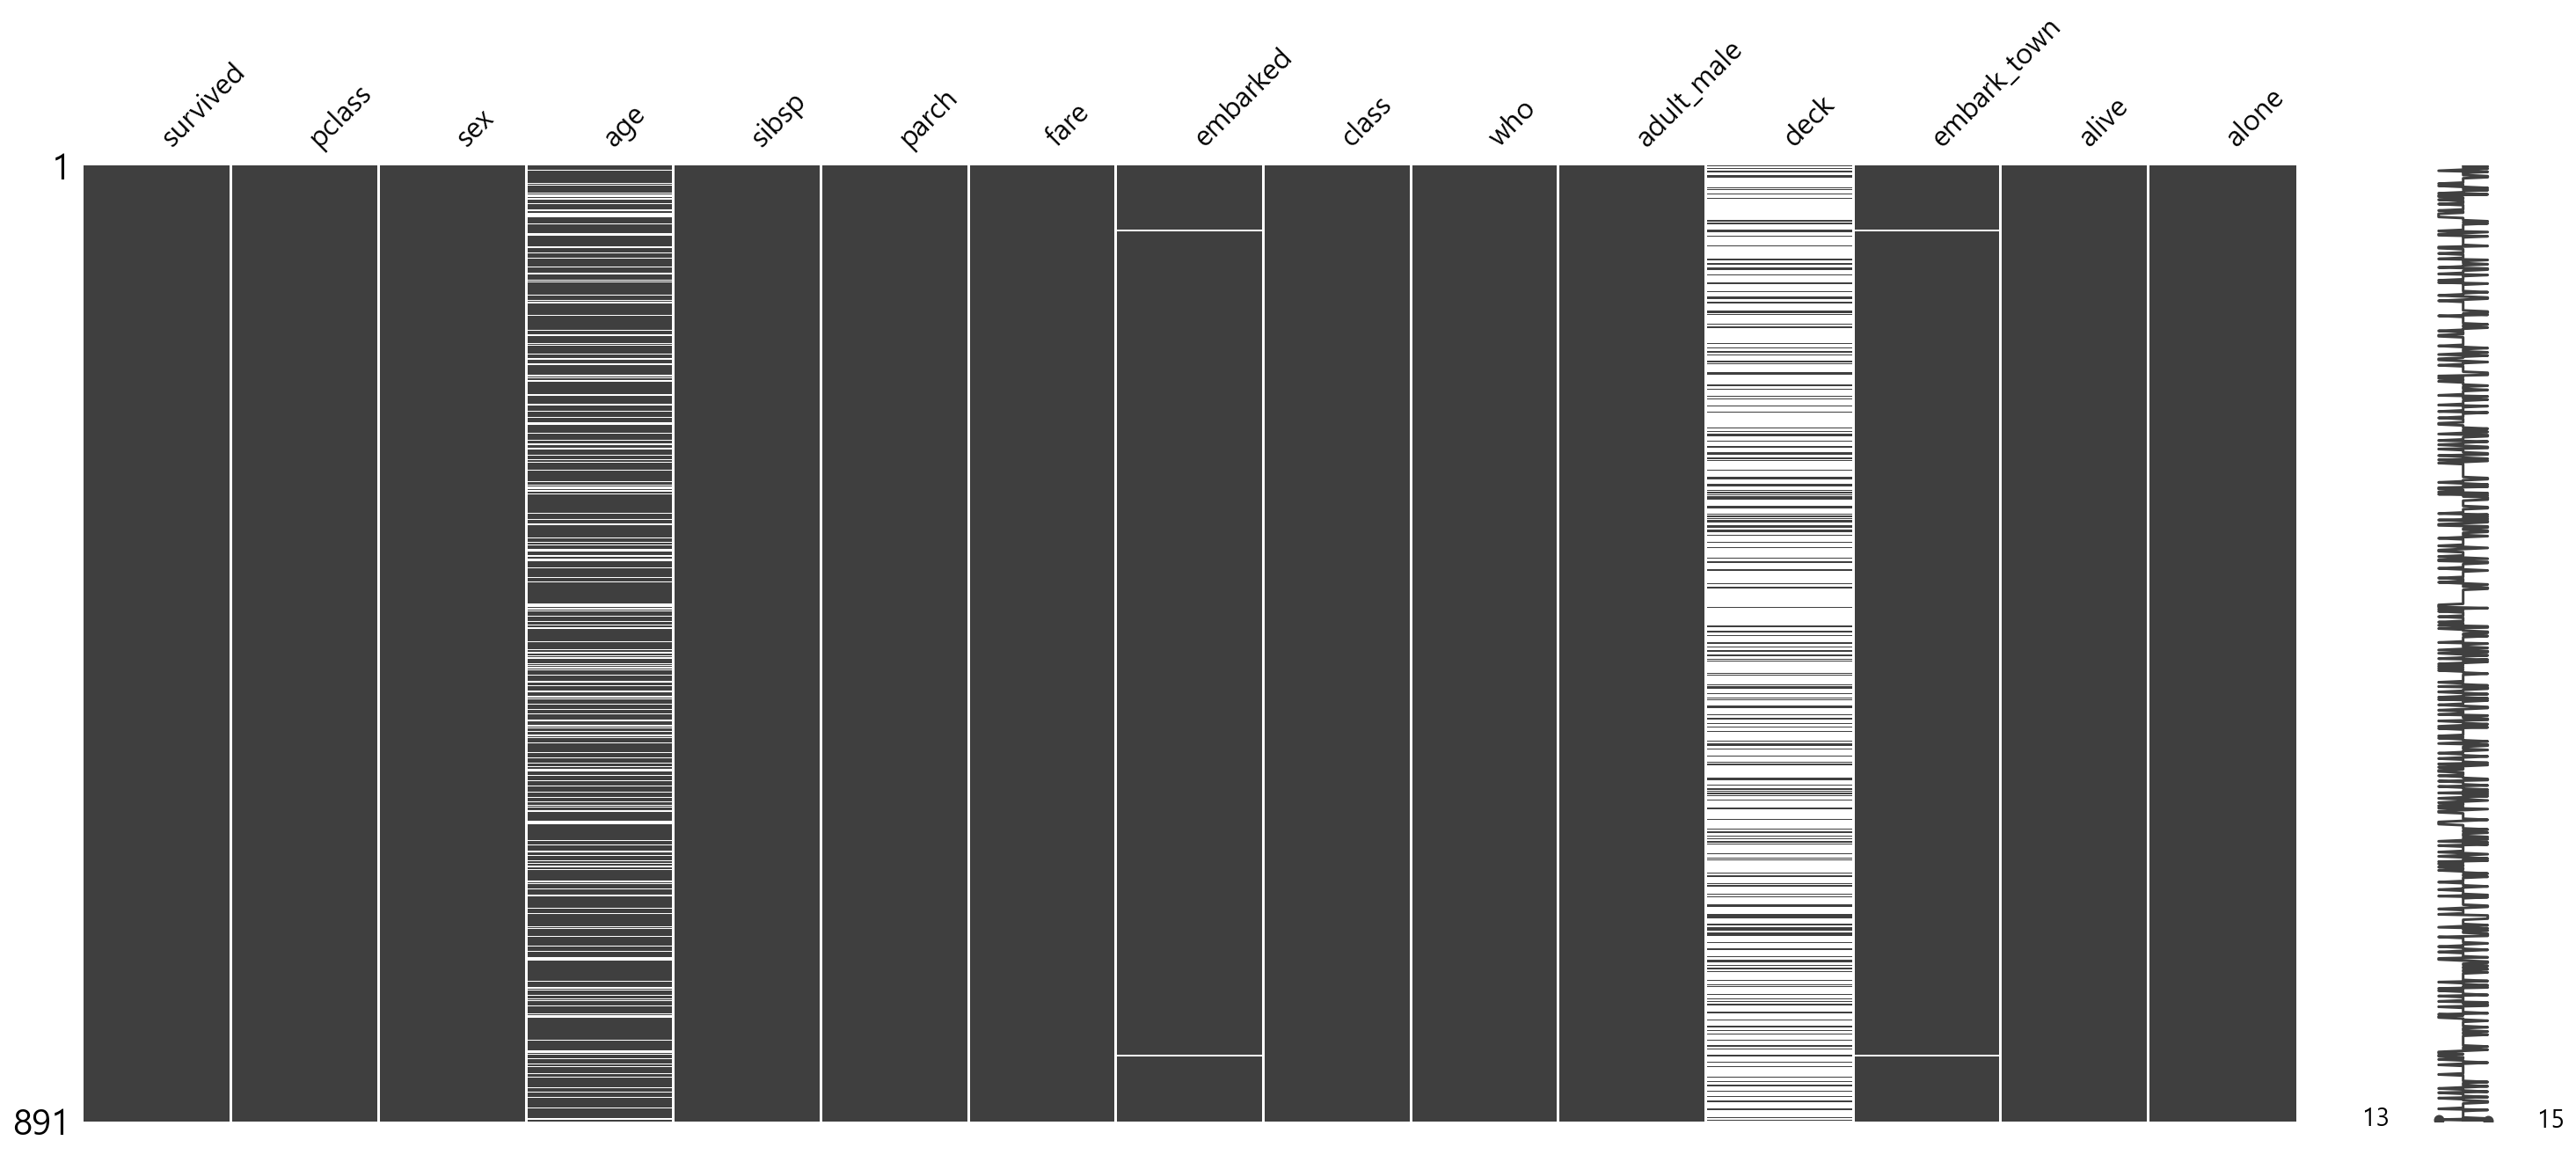

In [9]:
msno.matrix(titanic)
plt.show()

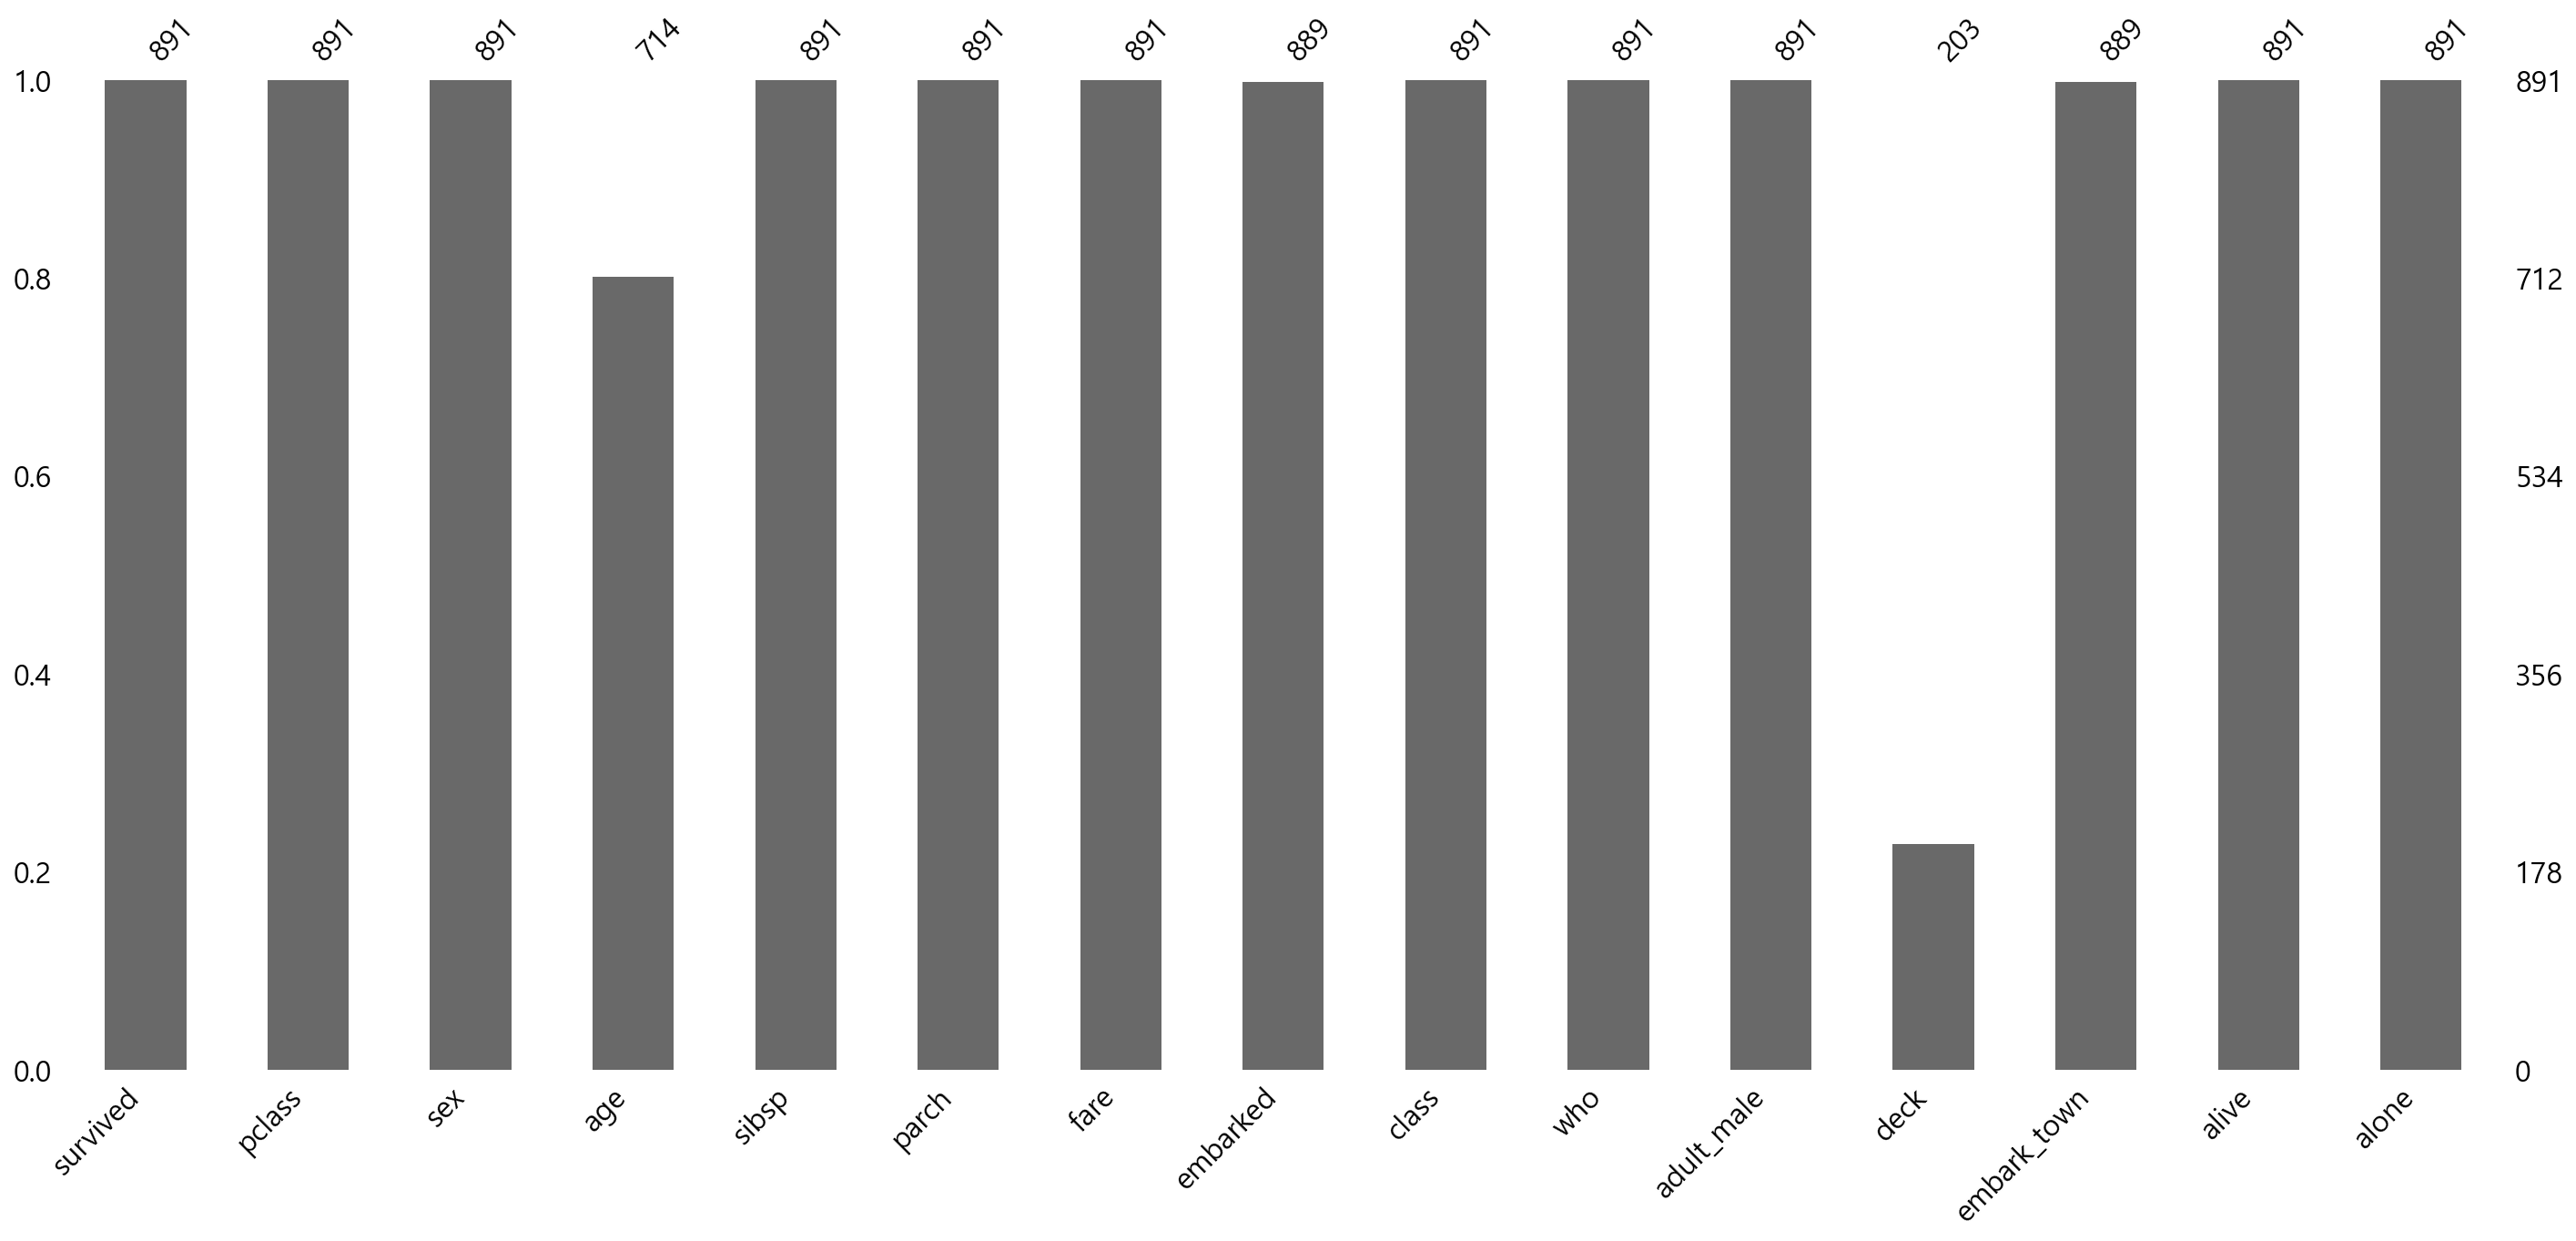

In [10]:
msno.bar(titanic)
plt.show()

missingno 패키지를 이용해 대량의 데이터에서도 어떤 피쳐에 결측치가 많은지를 직관적으로 확인할 수 있다.

## 결측치를 처리하는 방법

1. 결측치가 너무 많은 경우 해당 데이터 열 전체를 삭제
2. 결측치가 일부인 경우 특정 통계량, 머신러닝 등을 이용해 대체할 수 있다.(imputation)

`dropna()` : 결측치가 하나라도 존재하는 행을 모두 제거

In [11]:
df

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
1,2,NaN,NaN,2019-01-02,B
2,3,NaN,3.0,2019-01-03,C
3,<NA>,0.4,4.0,2019-01-04,A
4,5,0.5,5.0,2019-01-05,B
5,<NA>,NaN,NaN,2019-01-06,C
6,7,0.7,7.0,NaT,A
7,8,0.8,8.0,2019-01-08,B
8,9,0.9,NaN,2019-01-09,C


In [12]:
df.dropna()

,x1,x2,x3,x4,x5
0,1,0.1,1.0,2019-01-01,A
4,5,0.5,5.0,2019-01-05,B
7,8,0.8,8.0,2019-01-08,B


`thresh` 인수를 사용하면 특정 갯수 이상의 비결측 데이터가 있는 행 또는 열만 남김

In [13]:
df.dropna(thresh=7, axis=1)

,x1,x4,x5
0,1,2019-01-01,A
1,2,2019-01-02,B
2,3,2019-01-03,C
3,<NA>,2019-01-04,A
4,5,2019-01-05,B
5,<NA>,2019-01-06,C
6,7,NaT,A
7,8,2019-01-08,B
8,9,2019-01-09,C


타이타닉 데이터의 경우 deck 피처에 결측치가 다수 존재

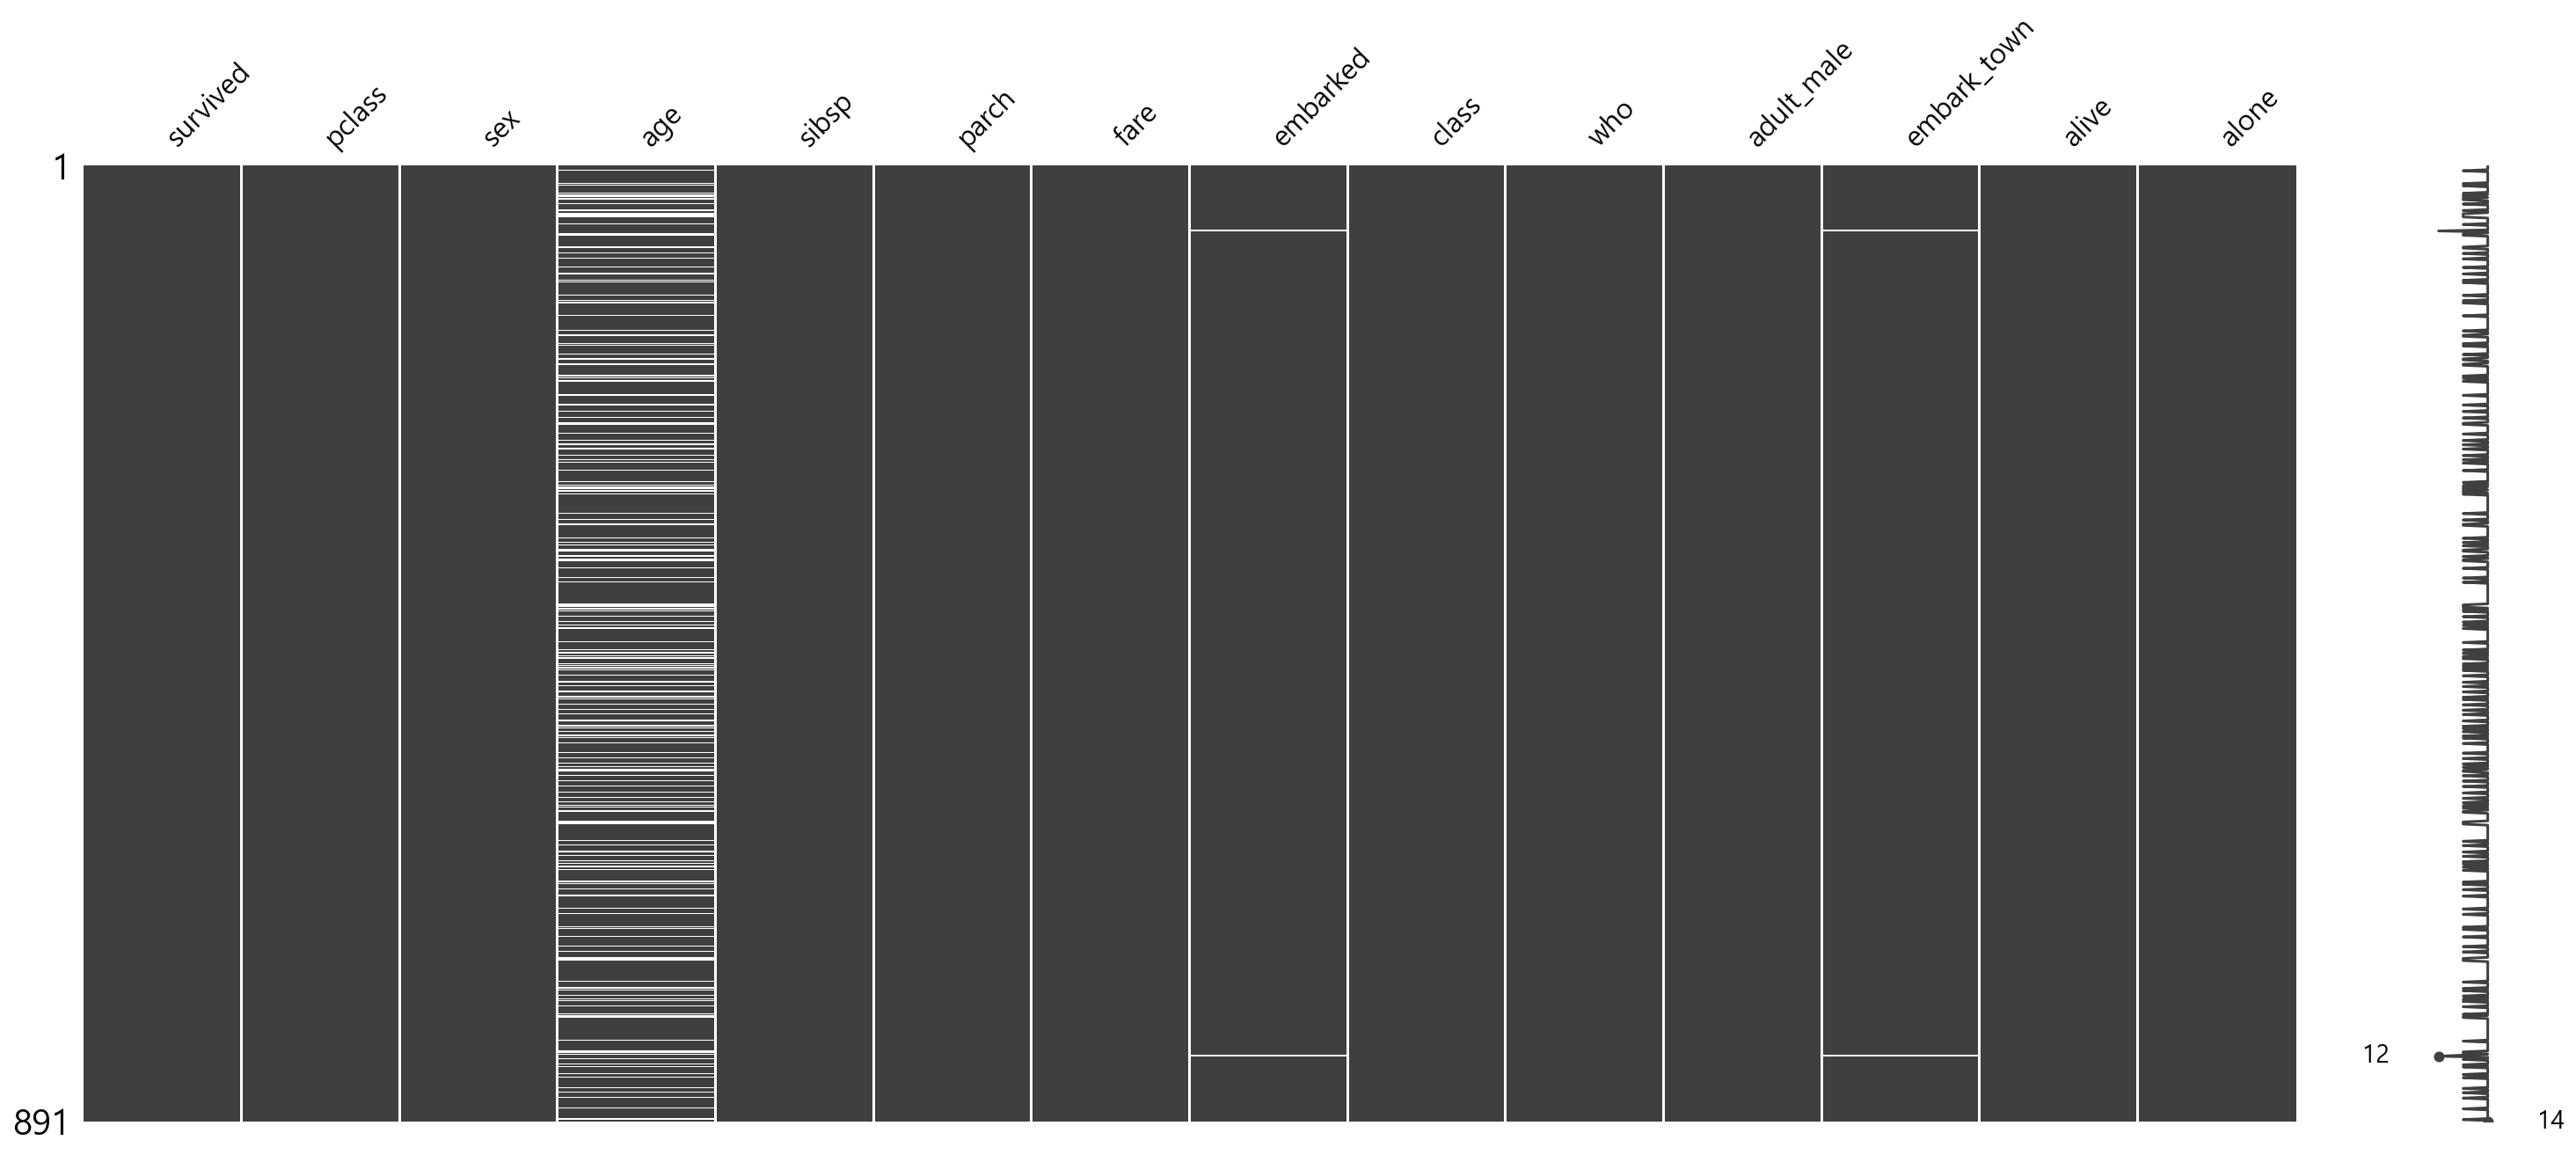

In [14]:
# 데이터가 절반 이상이 없는 열을 삭제
titanic = titanic.dropna(thresh=int(len(titanic) * 0.5), axis=1)
msno.matrix(titanic)
plt.show()

## SimpleImputer

SimpleImputer 클래스는 결측치 처리 기능을 제공한다.

`strategy` 인수를 mean으로 하면 평균, median으로 하면 중앙값, most_frequent로 하면 최빈값으로 대체한다.

`fit_transform` 메소드를 사용해 대체값이 채워진 DF를 생성한다.

1. 데이터가 연속하는 값인 경우 평균 또는 중앙값을 사용할 수 있다. 분포가 대칭적이면 평균, 분포가 비대칭인 경우 중앙값이 적합
2. 데이터가 범주형이거나 정수값이 경우 최빈값이 적합

타이타닉 데이터에서 `embark_town` 데이터를 대체

범주값이므로 strategy = "most_frequent"로 지정해 최빈값으로 대체

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


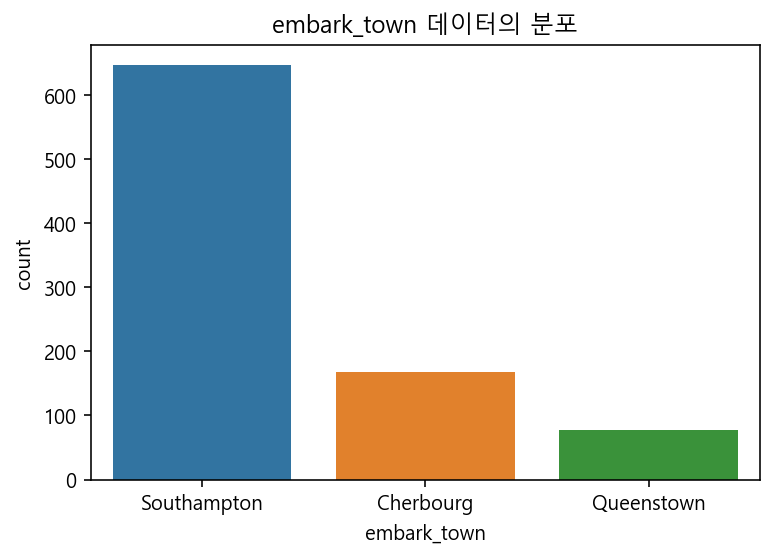

In [23]:
from sklearn.impute import SimpleImputer

sns.countplot(titanic.embark_town)
plt.title("embark_town 데이터의 분포")
plt.show()

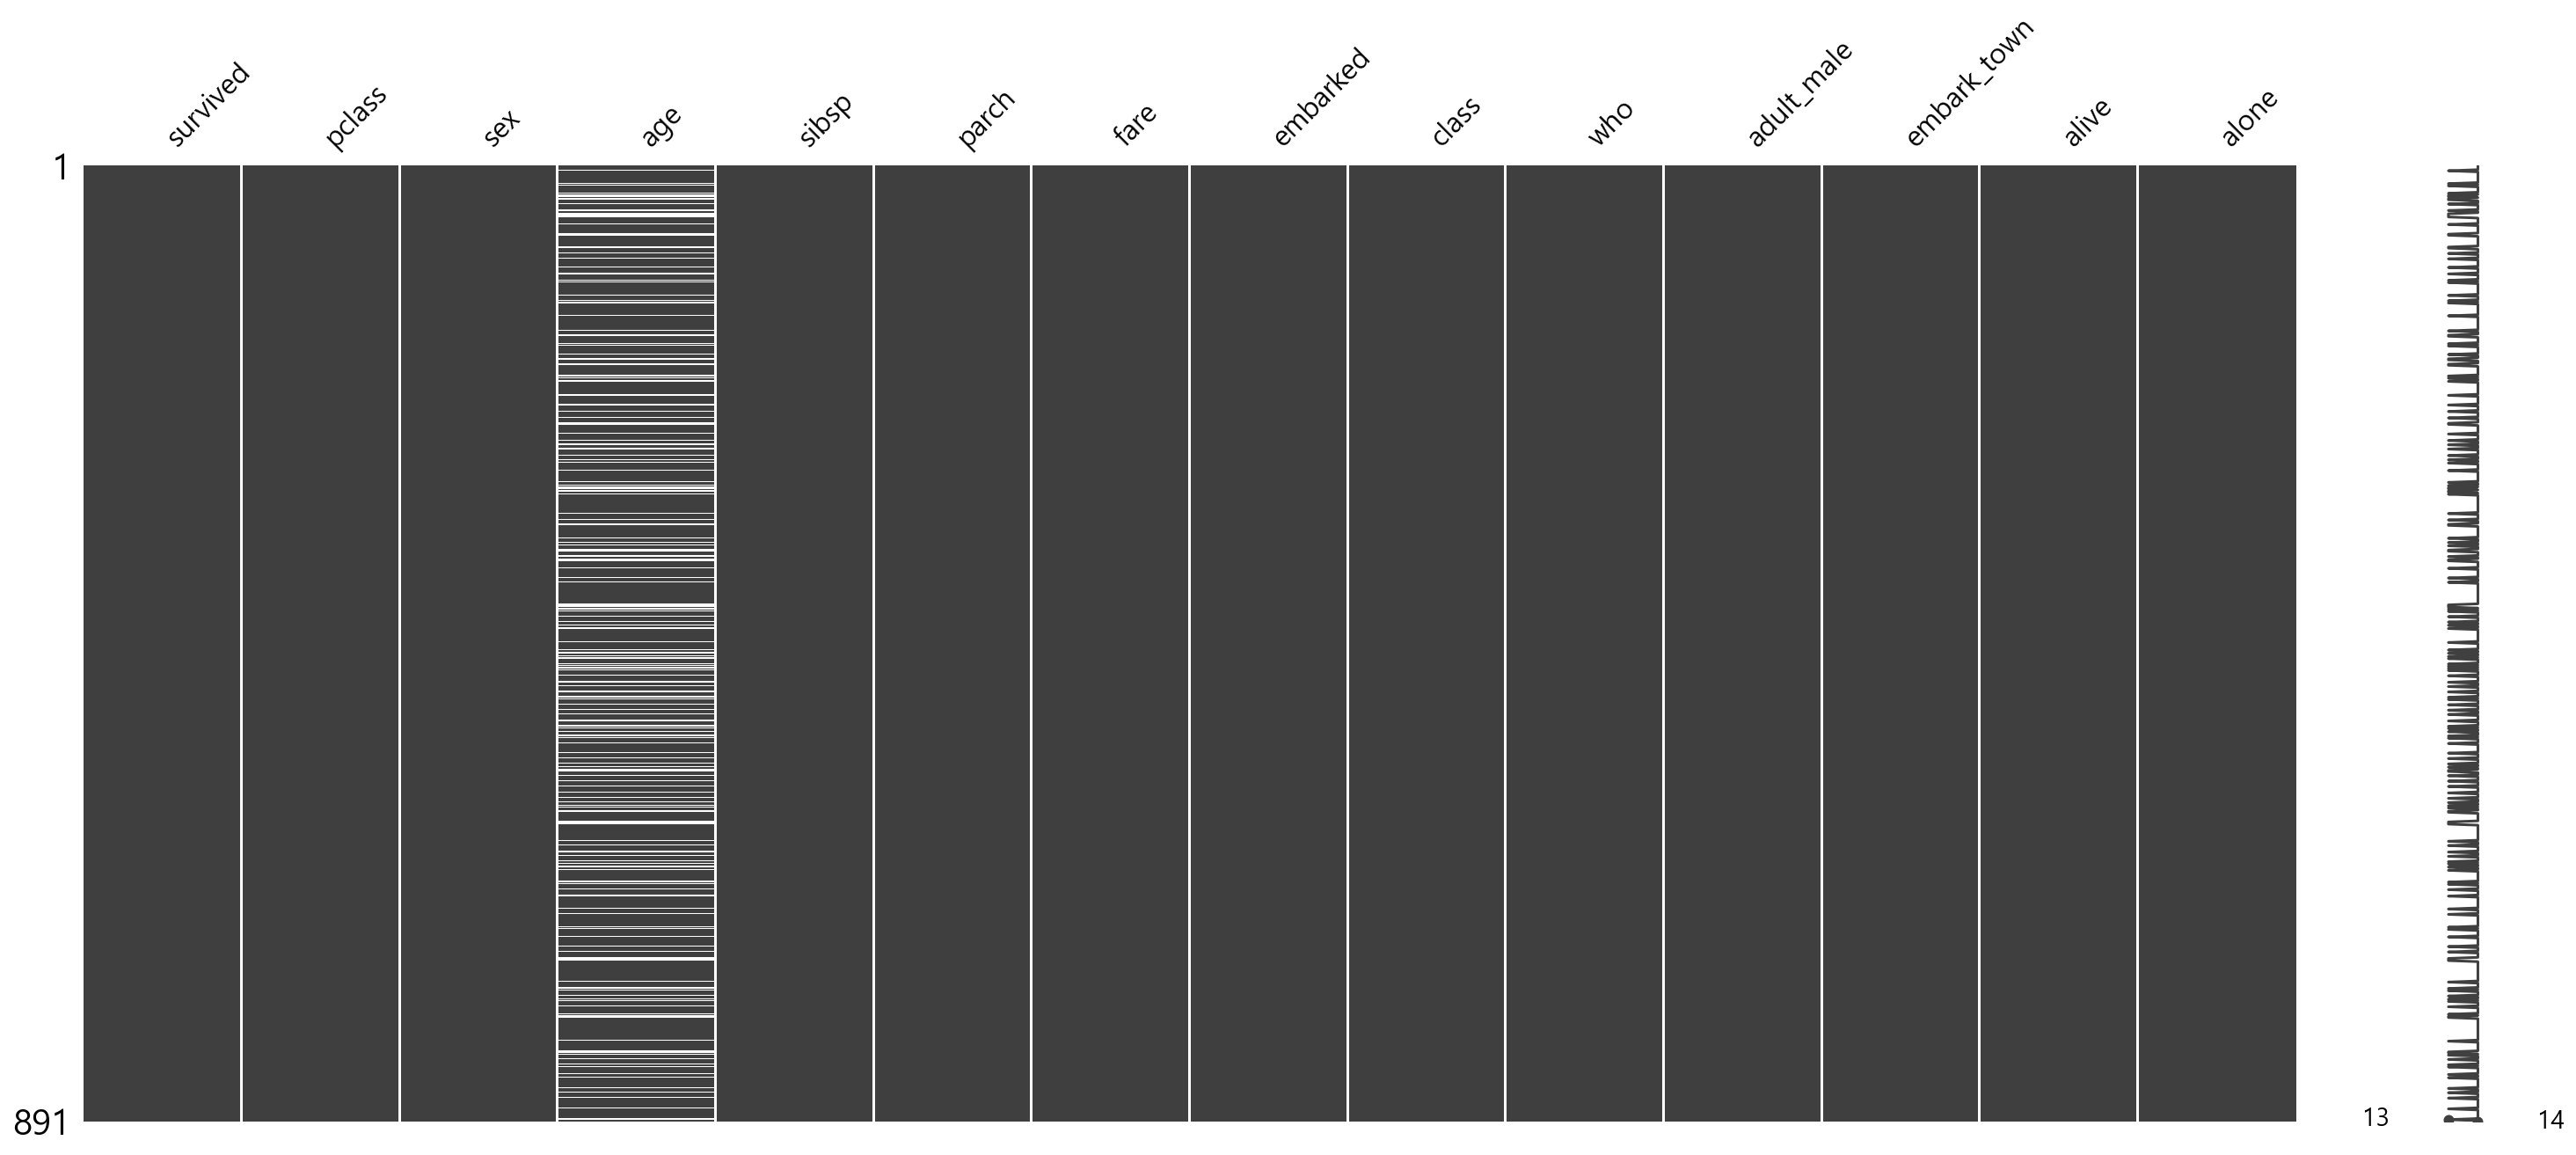

In [21]:
from sklearn.impute import SimpleImputer

imputer_embark_town = SimpleImputer(strategy="most_frequent")
titanic["embark_town"] = imputer_embark_town.fit_transform(titanic[["embark_town"]])
titanic["embarked"] = imputer_embark_town.fit_transform(titanic[["embarked"]])

msno.matrix(titanic)
plt.show()

이번에는 age 피처의 결측치를 중앙값으로 대체해보자

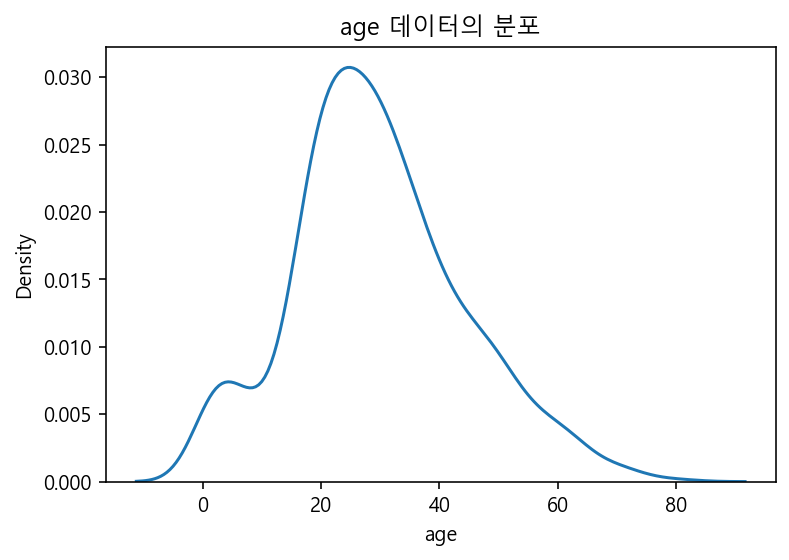

In [25]:
sns.kdeplot(titanic.age)
plt.title("age 데이터의 분포")
plt.show()

age 데이터의 분포처럼 비대칭으로 보이는 데이터의 특징은 양수값만을 가지는 데이터인 경우가 많다.

이 때는 평균보다는 median 값으로 대체하는 것이 적합하다.

age 피처의 결측치를 중앙값으로 대체

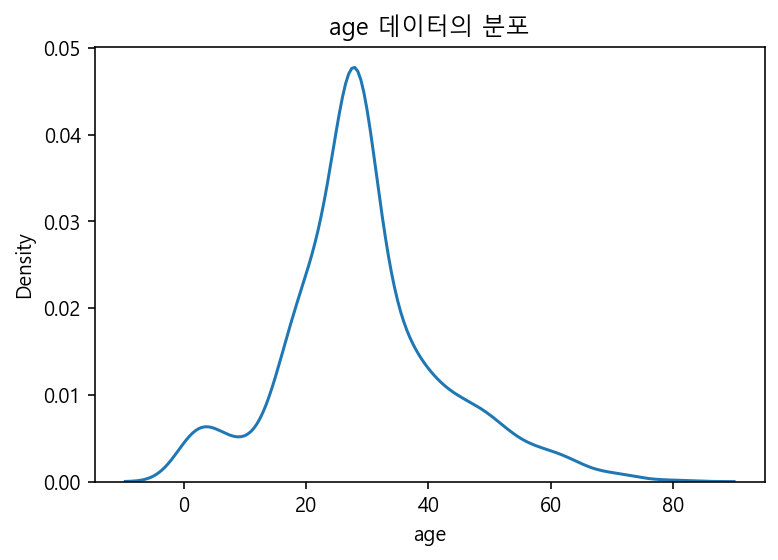

In [27]:
imputer_age = SimpleImputer(strategy='median')
titanic["age"] = imputer_age.fit_transform(titanic[["age"]])

sns.kdeplot(titanic.age)
plt.title("age 데이터의 분포")
plt.show()

결측치 처리 완료

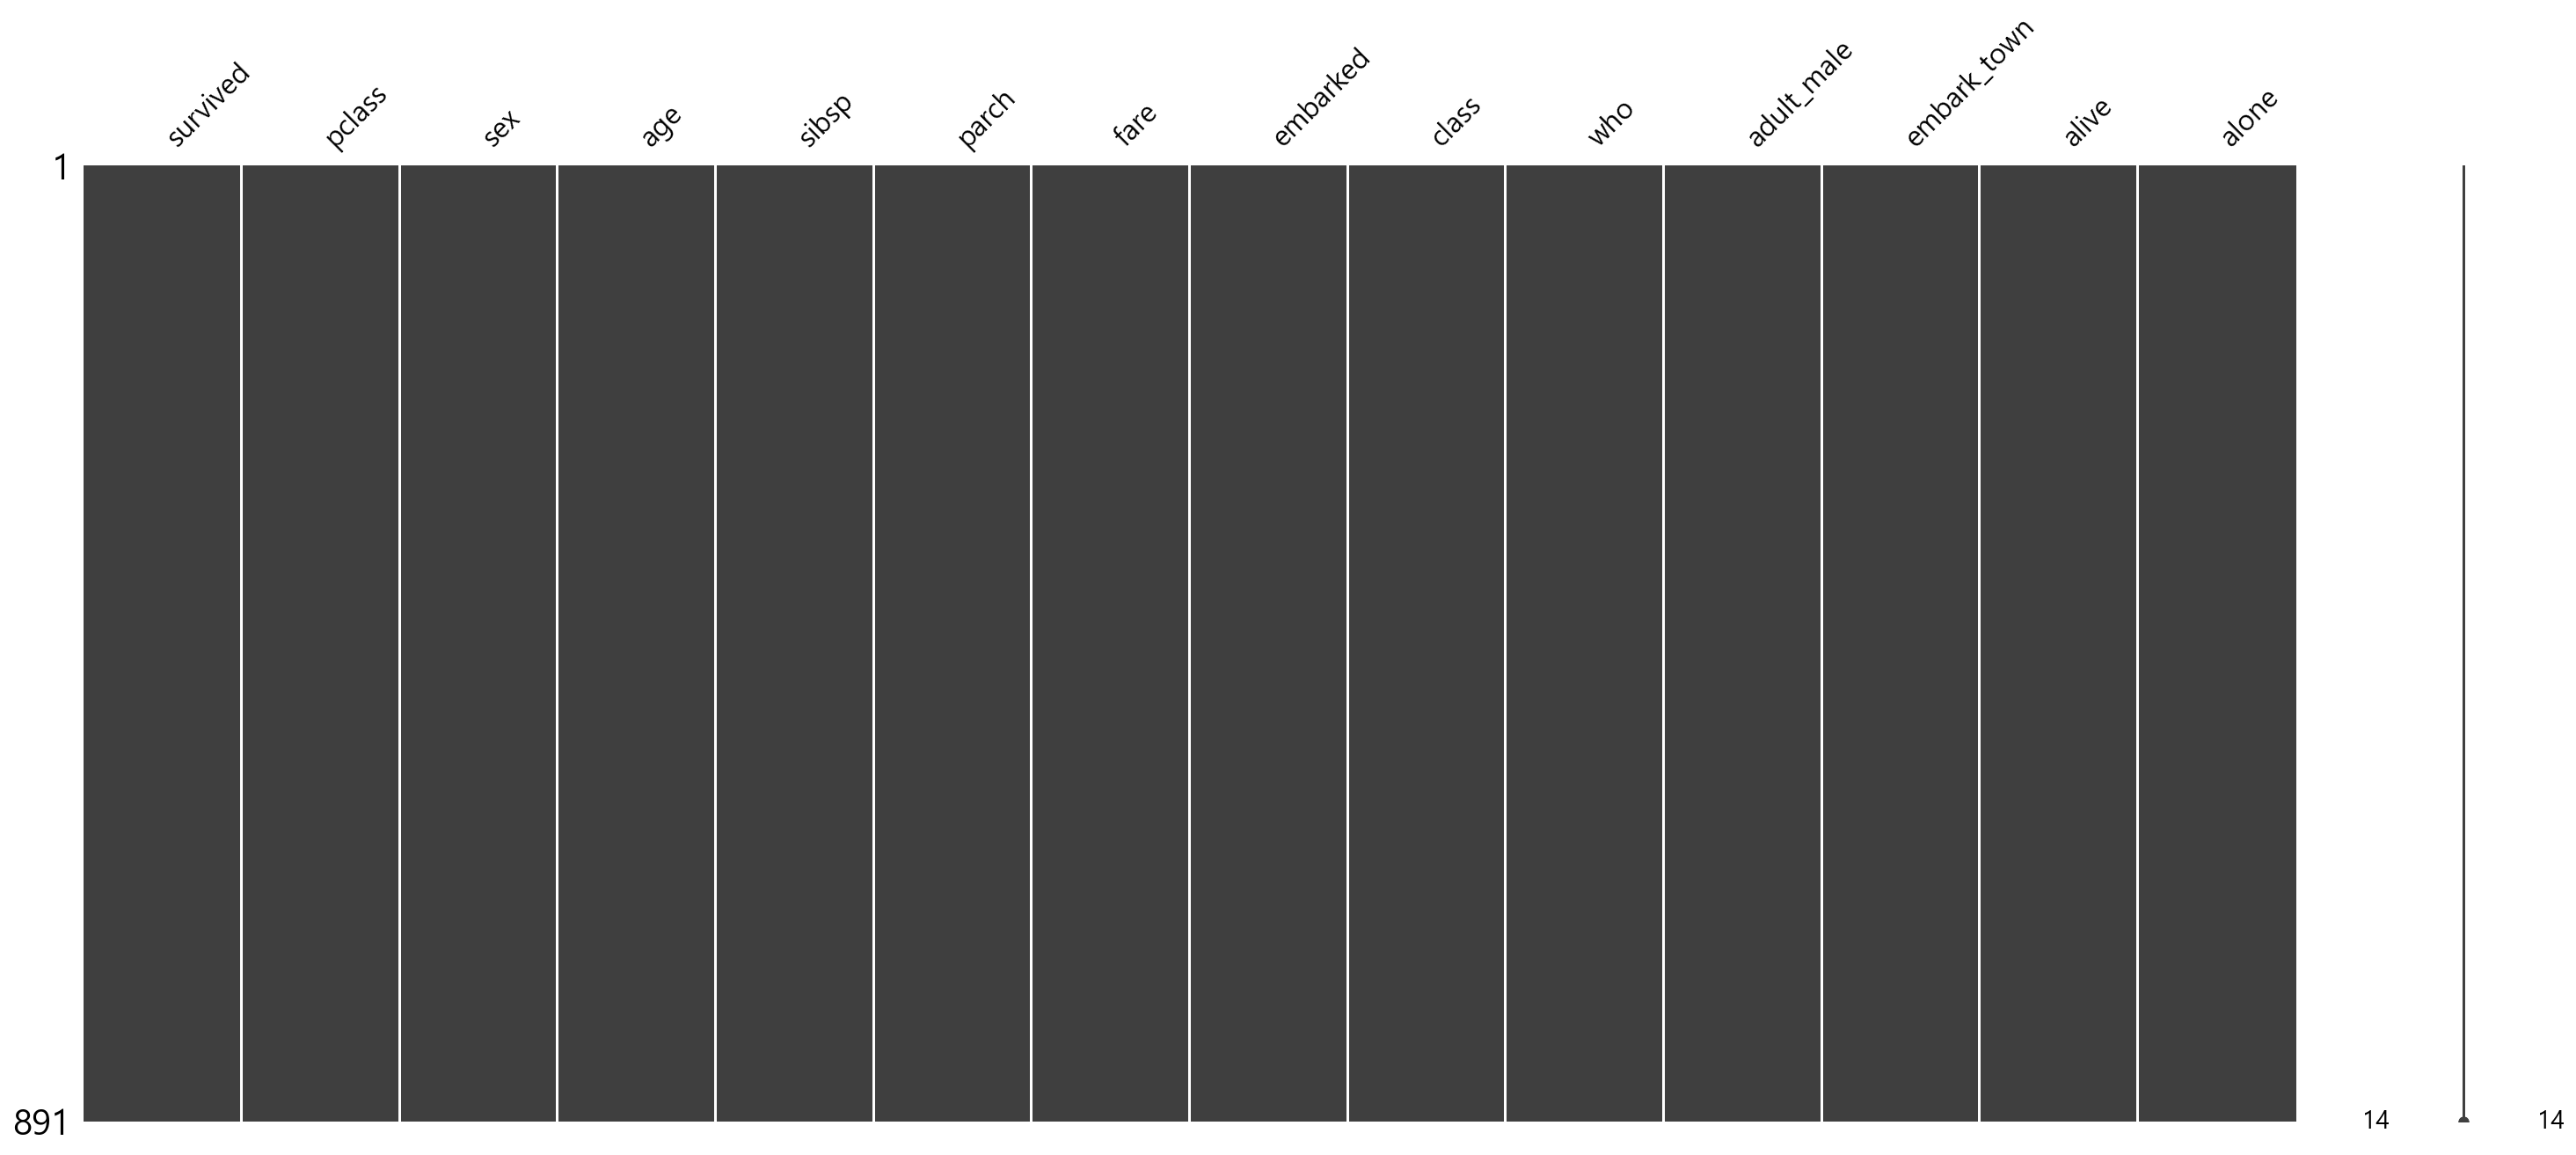

In [28]:
msno.matrix(titanic)
plt.show()